# Quick comparison of "Linear Combination" to "UV combination" #

This is a quick script to compare the 'linear combination' approach to the feathering/UV combination approach for a synthetic data set.  The code is fairly messy because the underlying functions are designed to run on FITS files, not on arrays, so I had to cut and past pieces.

In [122]:
# ipython notebook setup:
%matplotlib inline

In [123]:
import pylab as pl
pl.rcParams['image.interpolation'] = 'nearest'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (12,8)
pl.rcParams['image.cmap'] = 'viridis'
pl.rcParams['patch.edgecolor'] = 'none'
pl.rcParams['axes.prop_cycle'] = pl.cycler('color', ('#338ADD', '#9A44B6', '#A60628', '#467821', '#CF4457', '#188487', '#E24A33'))

In [124]:
from astropy import convolution
import numpy as np
from uvcombine.uvcombine import feather_kernel, fftmerge, linear_combine, feather_simple
from turbustat.simulator.gen_field import make_extended
from turbustat.statistics import psds

In [125]:
# create an input image with specified parameters
# (this can later be modified - it will be good to examine the effects of
# different power laws, different types of input...)
# We're assuming a scale of 1"/pixel for this example
imsize = 512
im = make_extended(imsize=imsize, powerlaw=1.5, randomseed=0)
# the real sky is positive.
im = im - im.min()

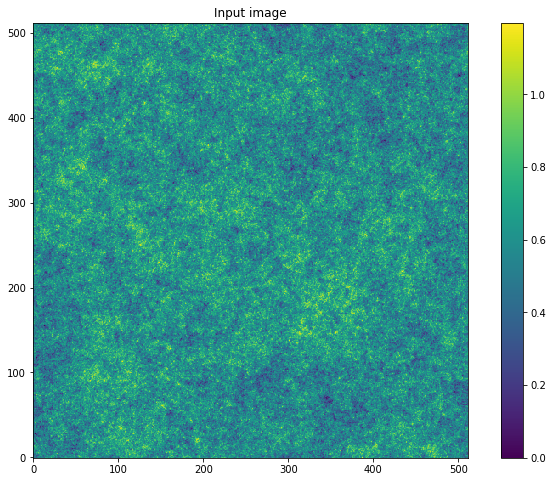

In [126]:
_=pl.imshow(im)
_=pl.title("Input image")
_=pl.colorbar()

In [127]:
ygrid, xgrid = np.indices(im.shape, dtype='float')
rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5

Create a UV sampling mask
-------------------------

This removes all large-angular scale (r<8) features *in UV space* and all small angular scales.

In fourier space, r=0 corresponds to the DC component
r=1 corresponds to the full map (one period over that map)
r=256 is the smallest angular scale, which is 2 pixels (nyquist sampling....?)

We're assuming a pixel scale of 1" / pixel
therefore 56" corresponds to 9m at 2mm (i.e., nearly the closest spacing possible for 7m)
We cut off the "interferometer" at 2.5" resolution

In [128]:
largest_scale = 56.
smallest_scale = 2.5
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

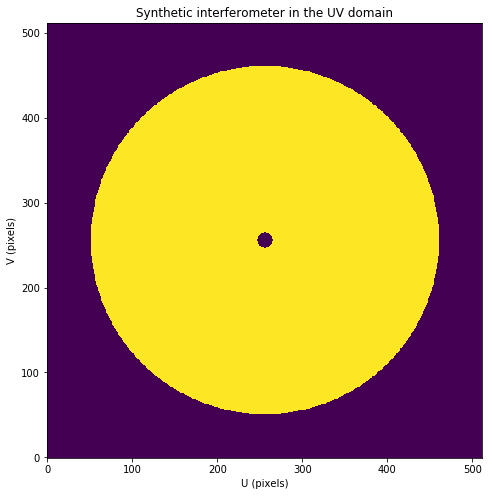

In [129]:
_=pl.imshow(ring)
_=pl.title("Synthetic interferometer in the UV domain")
_=pl.xlabel("U (pixels)")
_=pl.ylabel("V (pixels)")

### Create the interferometric map by removing both large and small angular scales in fourier space

In [130]:
imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered).real

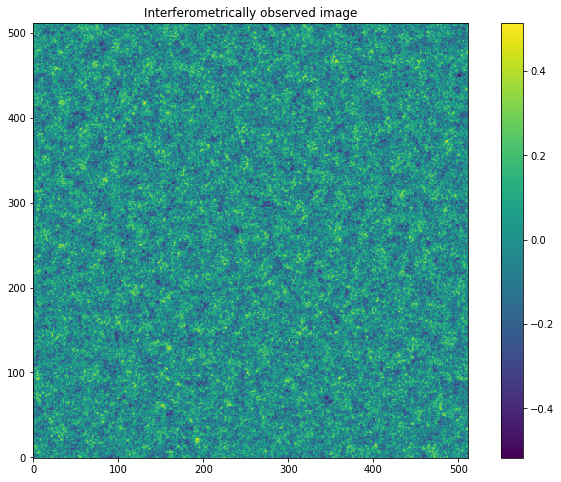

In [131]:
_=pl.imshow(im_interferometered)
_=pl.title("Interferometrically observed image")
_=pl.colorbar()

### Create the single-dish map by convolving the image with a FWHM=40" Gaussian kernel

(this interpretation is much easier than the sharp-edged stuff in fourier space because the kernel is created in real space)

In [132]:
lowresfwhm = 40
singledish_im = convolution.convolve_fft(im,
                                         convolution.Gaussian2DKernel(lowresfwhm/2.35),
                                         boundary='fill', fill_value=im.mean())

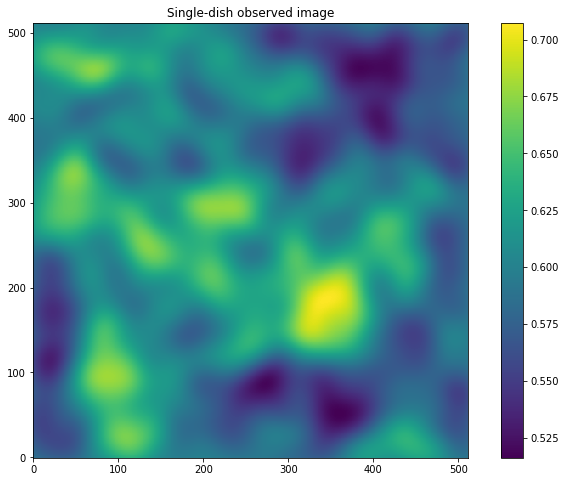

In [133]:
_=pl.imshow(singledish_im)
_=pl.title("Single-dish observed image")
_=pl.colorbar()

### Feather the data

This breaks the source code down; there's also a convenience function that achieves the same thing

In [134]:
# pixel scale can be interpreted as "arcseconds"
# then, fwhm=40 means a beam fwhm of 40"
pixscale = 1
lowresfwhm = 40
nax1,nax2 = im.shape
kfft, ikfft = feather_kernel(nax2, nax1, lowresfwhm, pixscale,)

In [135]:
im_hi = im_interferometered.real
im_low = singledish_im
lowresscalefactor=1
replace_hires = False
highpassfilterSD = False
deconvSD = False
highresscalefactor=1
fftsum, combo = fftmerge(kfft, ikfft, im_hi*highresscalefactor,
                         im_low*lowresscalefactor,
                         replace_hires=replace_hires,
                         highpassfilterSD=highpassfilterSD,
                         deconvSD=deconvSD,
                        )
combo = combo.real

### Do the linear combination

Linear combination is `singledish - smoothed_interferometric + interferometric` all done in the image domain

In [136]:
from astropy import units as u
import radio_beam
from astropy.convolution import convolve_fft, convolve
#lincombim = linear_combine(im_interferometered, im_low)
im_hi = im_interferometered
pixscale = 1*u.arcsec
beam_low = radio_beam.Beam(40*u.arcsec)

missing_flux = im_low - convolve_fft(im_hi, beam_low.as_kernel(pixscale))

lincombim = missing_flux + im_hi

### Plot to compare the outcomes

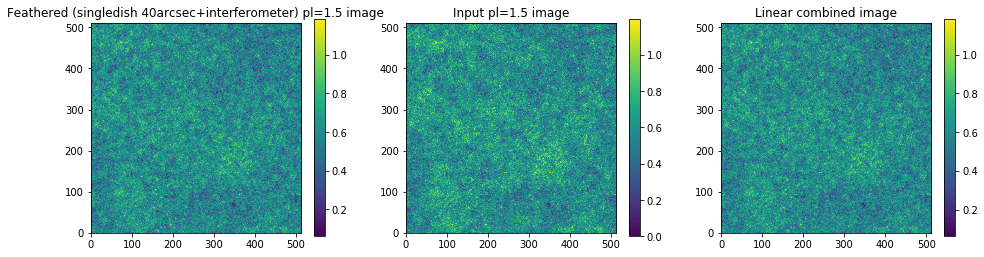

In [137]:
# Feathered dataset
_=pl.figure(1, figsize=(16,4)).clf()
_=pl.subplot(1,3,1)
_=pl.imshow(combo, cmap='viridis')
_=pl.colorbar()
_=pl.title("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
_=pl.subplot(1,3,2)
_=pl.imshow(im, cmap='viridis')
_=pl.colorbar()
_=pl.title("Input pl=1.5 image")
_=pl.subplot(1,3,3)
_=pl.imshow(lincombim, cmap='viridis')
_=pl.colorbar()
_=pl.title("Linear combined image")

It looks like feathering & linear combination have very similar results, as you might expect.

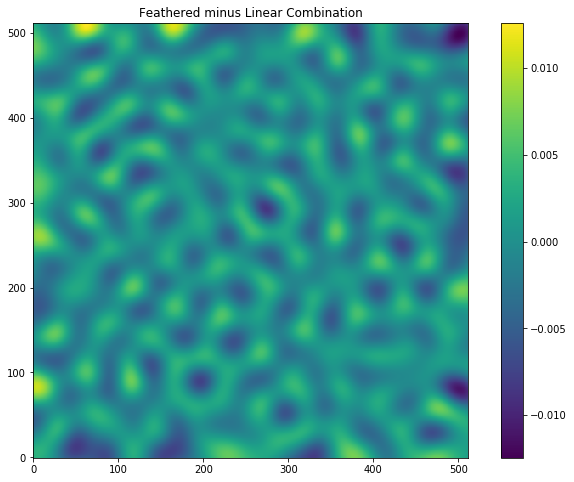

In [138]:
diff_feather_linear = combo-lincombim
_=pl.imshow(diff_feather_linear, cmap='viridis')
_=pl.colorbar()
_=pl.title("Feathered minus Linear Combination")

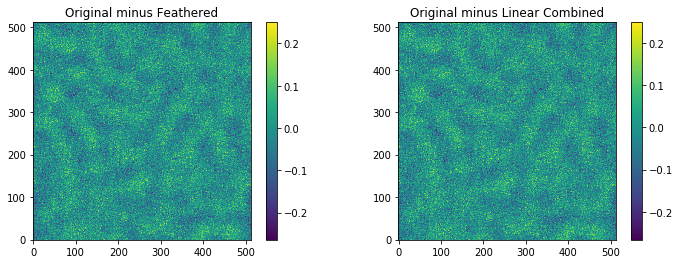

In [139]:
# Feathered dataset
_=pl.figure(1, figsize=(12,4)).clf()
_=pl.subplot(1,2,1)
_=pl.imshow(im - combo, cmap='viridis')
_=pl.colorbar()
_=pl.title("Original minus Feathered")
_=pl.subplot(1,2,2)
_=pl.imshow(im - lincombim, cmap='viridis')
_=pl.colorbar()
_=pl.title("Original minus Linear Combined")

## Power Spectra
A better way to compare images that are generated from power spectra is to compare their power spectra directly.

Clearly, neither feather nor linear combination works well in this regime.

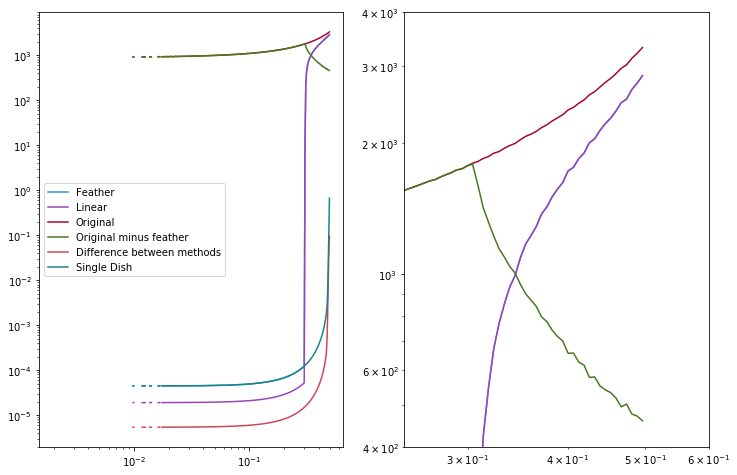

In [142]:
pl.figure(figsize=(12,8))
ax1 = pl.subplot(1,2,1)
ax2 = pl.subplot(1,2,2)
for thisim, name in ((combo, 'Feather'), (lincombim, 'Linear'), (im, 'Original'),
                     (im-combo, "Original minus feather"),                     
                     (diff_feather_linear, "Difference between methods"),
                     (singledish_im, 'Single Dish')
                    ):
    psd2 = np.abs(np.fft.fft2(thisim))**2
    pfreq, ppow = psds.pspec(psd2)
    ax1.loglog(pfreq, ppow, label=name)
    ax2.loglog(pfreq, ppow, label=name)
_=ax2.set_ylim(4e2, 0.4e4)
_=ax2.set_xlim(0.25, 0.6)
_=ax1.legend(loc='best')